#Face Classification with ResNet50 and MobileNet
## Dataset from Kaggle

Imports:

In [2]:
import os
import numpy as np
import torch
import pandas as pd
import torchvision
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from torchvision import models
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torchvision import transforms
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau


## Dataset Handling - Part 1

Donwloading dataset from kaggle with API key

In [5]:
import os
import shutil
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# Get current working directory
current_dir = os.getcwd()

# Set up Kaggle credentials directory
kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
os.makedirs(kaggle_dir, exist_ok=True)

# Copy kaggle.json from current directory to .kaggle folder
source_path = os.path.join(current_dir, 'kaggle.json')
destination_path = os.path.join(kaggle_dir, 'kaggle.json')
shutil.copy(source_path, destination_path)

# Set file permissions for the kaggle.json file
os.chmod(destination_path, 0o600)

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()

# Download competition data to the current directory
competition_name = 'face-classification-deep-learning-cs-405'
api.competition_download_files(competition_name)

# Create destination directory in the current project
face_data_dir = os.path.join(current_dir, 'face_data')
os.makedirs(face_data_dir, exist_ok=True)

# Unzip the downloaded file
zip_filename = f'{competition_name}.zip'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(face_data_dir)

print(f"Dataset extracted successfully to {face_data_dir}")

Dataset extracted successfully to C:\Users\wadoo\PycharmProjects\JupyterProject3\face_data


In [3]:
for root, dirs, files in os.walk("/face_data"):
    # Looking for test folders
    if "test" in root.lower() or any("test" in f.lower() for f in files):
        print(f"Found: {root}")
        print(f"Sample files: {files[:5]}")

### Defining Transformations (including normalizing)

In [4]:
# Define transformations for training with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to standard input size
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),  # Slight rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust color
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# For testing, no augmentation, just normalizing
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Loading data
data = datasets.ImageFolder(root='./face_data/dataset/train', transform=train_transform)

Splitting training data into 80% train and 20% validation sets

In [6]:
trainLen = int(0.8 * len(data))
valLen = len(data) - trainLen
trainData, valData = random_split(data, [trainLen, valLen])

In [7]:
trainLoader = DataLoader(trainData, batch_size=32, shuffle=True)
valLoader = DataLoader(valData, batch_size=32, shuffle=False)

## Deep Face Classifier - Part 2

### ResNet:

Training Functions

In [37]:
import time

def training(model, trainLoader, valLoader, lossFunction, optimizer, epochs):
    trainLoss, valLoss = [], []
    valAccuracies = []
    bestValidLoss = float('inf')
    bestModelState = None

    # Add learning rate scheduler for better convergence
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    # Add early stopping mechanism
    patience = 7
    early_stop_counter = 0

    for epoch in range(epochs):
        model.train()
        runningLoss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        # Batch progress printing frequency (every 25% of the dataset)
        print_freq = max(1, len(trainLoader) // 4)

        for i, (images, labels) in enumerate(trainLoader):
            images, labels = images.to(device), labels.to(device)

            # Zero gradients for every batch
            optimizer.zero_grad()

            # Mixed precision training for speed improvement
            with torch.cuda.amp.autocast(enabled=True):
                outputs = model(images)
                loss = lossFunction(outputs, labels)

            # Backpropagation
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimize
            optimizer.step()

            # Statistics
            runningLoss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Print batch progress at specified intervals
            if (i + 1) % print_freq == 0 or (i + 1) == len(trainLoader):
                progress = (i + 1) / len(trainLoader) * 100
                batch_loss = runningLoss / (i + 1)
                batch_acc = 100.0 * correct / total
                print(f'Epoch: {epoch+1}/{epochs} | Progress: {progress:.1f}% | Batch Loss: {batch_loss:.4f} | Batch Acc: {batch_acc:.2f}%', end='\r')

        # Clear the progress line
        print(' ' * 100, end='\r')

        # Calculate average training metrics
        avgTrainLoss = runningLoss / len(trainLoader)
        trainAcc = 100.0 * correct / total
        epoch_time = time.time() - start_time

        # Evaluate on validation set
        model.eval()
        valRunningLoss = 0.0
        valCorrect = 0
        valTotal = 0

        with torch.no_grad():
            for images, labels in valLoader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = lossFunction(outputs, labels)

                valRunningLoss += loss.item()
                _, predicted = outputs.max(1)
                valTotal += labels.size(0)
                valCorrect += predicted.eq(labels).sum().item()

        avgValLoss = valRunningLoss / len(valLoader)
        valAcc = 100.0 * valCorrect / valTotal

        # Store metrics
        trainLoss.append(avgTrainLoss)
        valLoss.append(avgValLoss)
        valAccuracies.append(valAcc)

        # Update learning rate based on validation loss
        scheduler.step(avgValLoss)

        # Print epoch summary with elapsed time
        print(f"Epoch {epoch+1}/{epochs} [{epoch_time:.1f}s]")
        print(f"  Train: Loss {avgTrainLoss:.4f} | Acc {trainAcc:.2f}%")
        print(f"  Val:   Loss {avgValLoss:.4f} | Acc {valAcc:.2f}%")
        print(f"  LR:    {optimizer.param_groups[0]['lr']:.2e}")

        # Save best model
        if avgValLoss < bestValidLoss:
            bestValidLoss = avgValLoss
            bestModelState = model.state_dict()
            torch.save(bestModelState, "./resnet18.pth")
            print("  Best model saved (val loss improved)")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"  Early stop counter: {early_stop_counter}/{patience}")

        print("-" * 60)

        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

    # Load best model before returning
    model.load_state_dict(bestModelState)

    return trainLoss, valLoss, valAccuracies

In [32]:
def evaluate(model, valLoader, lossFunction):
    model.eval()
    totalLoss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = lossFunction(outputs, labels)
            totalLoss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = totalLoss / len(valLoader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

Checking cuda connection

In [33]:
print(torch.cuda.is_available())

True


### Model Training

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lossFunction = nn.CrossEntropyLoss()
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 7000)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
trainLoss, valLoss, valAccuracies = training(model, trainLoader, valLoader, lossFunction, optimizer, epochs=5)


cuda


C:\Users\wadoo\AppData\Local\Temp\ipykernel_12092\38192514.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 1/5 [713.8s]                                                                                  
  Train: Loss 8.9700 | Acc 0.01%
  Val:   Loss 8.8938 | Acc 0.00%
  LR:    1.00e-03
  Best model saved (val loss improved)
------------------------------------------------------------
Epoch 2/5 [696.6s]                                                                                  
  Train: Loss 8.8490 | Acc 0.02%
  Val:   Loss 8.9013 | Acc 0.00%
  LR:    1.00e-03
  Early stop counter: 1/7
------------------------------------------------------------
Epoch 3/5 [716.6s]                                                                                  
  Train: Loss 8.7199 | Acc 0.04%
  Val:   Loss 8.4044 | Acc 0.09%
  LR:    1.00e-03
  Best model saved (val loss improved)
------------------------------------------------------------
Epoch 4/5 [678.9s]                                                                                  
  Train: Loss 7.4641 | Acc 0.97%
  Val:   Loss 6.7670 | A

In [39]:
# loading weights
model.load_state_dict(torch.load("./resnet18.pth", map_location=device))

<All keys matched successfully>

Another 5 epochs as not converged:

In [41]:
print(device)
trainLoss, valLoss, valAccuracies = training(model, trainLoader, valLoader, lossFunction, optimizer, epochs=5)

C:\Users\wadoo\AppData\Local\Temp\ipykernel_12092\38192514.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 1/5 [678.4s]                                                                                  
  Train: Loss 1.8166 | Acc 62.58%
  Val:   Loss 3.1159 | Acc 45.38%
  LR:    1.00e-03
  Best model saved (val loss improved)
------------------------------------------------------------
Epoch 2/5 [659.5s]                                                                                  
  Train: Loss 1.7170 | Acc 64.44%
  Val:   Loss 2.8705 | Acc 48.99%
  LR:    1.00e-03
  Best model saved (val loss improved)
------------------------------------------------------------
Epoch 3/5 [657.1s]                                                                                  
  Train: Loss 1.6306 | Acc 65.98%
  Val:   Loss 2.8470 | Acc 48.82%
  LR:    1.00e-03
  Best model saved (val loss improved)
------------------------------------------------------------
Epoch 4/5 [675.5s]                                                                                  
  Train: Loss 1.5533 | Acc 67.46%
  Va

In [43]:
# loading weights
model.load_state_dict(torch.load("./resnet18.pth", map_location=device))

<All keys matched successfully>

Another 8 epochs as not converged:

In [44]:
print(device)
trainLoss, valLoss, valAccuracies = training(model, trainLoader, valLoader, lossFunction, optimizer, epochs=8)

cuda


C:\Users\wadoo\AppData\Local\Temp\ipykernel_12092\38192514.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch 1/8 [849.2s]                                                                                  
  Train: Loss 1.4852 | Acc 68.46%
  Val:   Loss 2.8561 | Acc 49.48%
  LR:    1.00e-03
  Best model saved (val loss improved)
------------------------------------------------------------
Epoch 2/8 [653.4s]                                                                                  
  Train: Loss 1.4184 | Acc 69.84%
  Val:   Loss 2.8283 | Acc 50.32%
  LR:    1.00e-03
  Best model saved (val loss improved)
------------------------------------------------------------
Epoch 3/8 [664.1s]                                                                                  
  Train: Loss 1.3713 | Acc 70.67%
  Val:   Loss 2.6842 | Acc 51.99%
  LR:    1.00e-03
  Best model saved (val loss improved)
------------------------------------------------------------
Epoch 4/8 [654.3s]                                                                                  
  Train: Loss 1.3220 | Acc 71.57%
  Va

Visualizing:

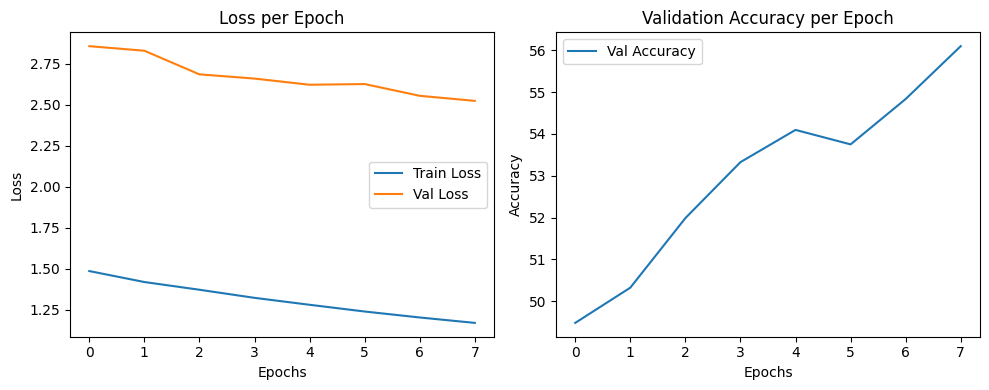

In [45]:
plt.figure(figsize=(10, 4))

# loss Plot
plt.subplot(1, 2, 1)
plt.plot(trainLoss, label='Train Loss')
plt.plot(valLoss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(valAccuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


###MobileNet:

In [52]:
# Load pre-trained MobileNet v2 model
model = torchvision.models.mobilenet_v2(pretrained=True)

# Modifying final classifier layer to output 7000 classes
num_classes = 7000
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

In [53]:
# Using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

# Loss function and optimizer
lossFunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# Setting schedular
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Changed training model for MobileNet for better metrics output:

In [54]:
def training(model, trainLoader, valLoader, lossFunction, optimizer, scheduler, epochs):
    trainLoss, valLoss = [], []
    valAccuracies = []
    bestValidLoss = float('inf')
    bestModelState = None

    for epoch in range(epochs):
        model.train()
        runningLoss = 0.0
        allPredictions = []
        allLabels = []

        pbar = tqdm(trainLoader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            # Calculating loss
            loss = lossFunction(outputs, labels)


            loss.backward()
            optimizer.step()  # Update step

            runningLoss += loss.item()

            preds = outputs.argmax(dim=1)
            allPredictions.extend(preds.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())

            pbar.set_postfix({"loss": loss.item()})

        avgTrainLoss = runningLoss / len(trainLoader)
        trainAcc = accuracy_score(allLabels, allPredictions)

        avgValLoss, valAcc = evaluate(model, valLoader, lossFunction)
        scheduler.step(avgValLoss)  # For ReduceLROnPlateau

        # metric updates
        trainLoss.append(avgTrainLoss)
        valLoss.append(avgValLoss)
        valAccuracies.append(valAcc)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avgTrainLoss:.4f} | Train Acc: {trainAcc:.4f} | Val Loss: {avgValLoss:.4f} | Val Acc: {valAcc:.4f} | LR: {current_lr:.6f}")

        # saving best model
        if avgValLoss < bestValidLoss:
            bestValidLoss = avgValLoss
            bestModelState = model.state_dict()
            torch.save(bestModelState, "./mobileNet.pth")
            print("Best model saved at epoch", epoch+1)

    return trainLoss, valLoss, valAccuracies


In [55]:
def evaluate(model, valLoader, lossFunction):
    # Set model to evaluation mode
    model.eval()
    totalLoss = 0.0
    allPredictions = []
    allLabels = []

    with torch.no_grad():
        for images, labels in valLoader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = lossFunction(outputs, labels)
            totalLoss += loss.item()

            preds = outputs.argmax(dim=1)
            allPredictions.extend(preds.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())

    avg_loss = totalLoss / len(valLoader)
    accuracy = accuracy_score(allLabels, allPredictions)
    return avg_loss, accuracy

In [20]:
print(device)
trainLoss, valLoss, valAccuracies = training(model, trainLoader, valLoader, lossFunction, optimizer, scheduler, epochs=5)
# loading best model
model_path = './mobileNet.pth'
if os.path.exists(model_path):
    print(f"Loading saved model from {model_path}")
    model.load_state_dict(torch.load(model_path))

cuda


Epoch 1/5: 100%|██████████| 3500/3500 [20:14<00:00,  2.88it/s, loss=8.54]


Epoch 1/5 | Train Loss: 8.7817 | Train Acc: 0.0002 | Val Loss: 8.5001 | Val Acc: 0.0004 | LR: 0.000100
Best model saved at epoch 1


Epoch 2/5: 100%|██████████| 3500/3500 [15:54<00:00,  3.67it/s, loss=6.67]


Epoch 2/5 | Train Loss: 7.8347 | Train Acc: 0.0032 | Val Loss: 6.7752 | Val Acc: 0.0158 | LR: 0.000100
Best model saved at epoch 2


Epoch 3/5: 100%|██████████| 3500/3500 [13:52<00:00,  4.20it/s, loss=4.95]


Epoch 3/5 | Train Loss: 5.7676 | Train Acc: 0.0680 | Val Loss: 4.8803 | Val Acc: 0.1554 | LR: 0.000100
Best model saved at epoch 3


Epoch 4/5: 100%|██████████| 3500/3500 [12:13<00:00,  4.77it/s, loss=4.07]


Epoch 4/5 | Train Loss: 4.1028 | Train Acc: 0.2381 | Val Loss: 3.8881 | Val Acc: 0.2897 | LR: 0.000100
Best model saved at epoch 4


Epoch 5/5: 100%|██████████| 3500/3500 [12:21<00:00,  4.72it/s, loss=3.27]


Epoch 5/5 | Train Loss: 3.1678 | Train Acc: 0.3860 | Val Loss: 3.2812 | Val Acc: 0.3894 | LR: 0.000100
Best model saved at epoch 5
Loading saved model from ./mobileNet.pth


Running model for another 5 epochs as not converged yet:

In [21]:
trainLoss, valLoss, valAccuracies = training(model, trainLoader, valLoader, lossFunction, optimizer, scheduler, epochs=5)

Epoch 1/5: 100%|██████████| 3500/3500 [12:30<00:00,  4.66it/s, loss=1.93]


Epoch 1/5 | Train Loss: 2.4965 | Train Acc: 0.5041 | Val Loss: 2.8575 | Val Acc: 0.4660 | LR: 0.000100
Best model saved at epoch 1


Epoch 2/5: 100%|██████████| 3500/3500 [12:10<00:00,  4.79it/s, loss=2.42] 


Epoch 2/5 | Train Loss: 1.9991 | Train Acc: 0.5975 | Val Loss: 2.5377 | Val Acc: 0.5219 | LR: 0.000100
Best model saved at epoch 2


Epoch 3/5: 100%|██████████| 3500/3500 [12:08<00:00,  4.81it/s, loss=1.73] 


Epoch 3/5 | Train Loss: 1.6342 | Train Acc: 0.6669 | Val Loss: 2.3381 | Val Acc: 0.5639 | LR: 0.000100
Best model saved at epoch 3


Epoch 4/5: 100%|██████████| 3500/3500 [14:25<00:00,  4.05it/s, loss=1.24] 


Epoch 4/5 | Train Loss: 1.3653 | Train Acc: 0.7176 | Val Loss: 2.2062 | Val Acc: 0.5888 | LR: 0.000100
Best model saved at epoch 4


Epoch 5/5: 100%|██████████| 3500/3500 [15:17<00:00,  3.82it/s, loss=1.56] 


Epoch 5/5 | Train Loss: 1.1511 | Train Acc: 0.7602 | Val Loss: 2.0729 | Val Acc: 0.6156 | LR: 0.000100
Best model saved at epoch 5


In [56]:
# loading best model
model_path = './mobileNet.pth'
if os.path.exists(model_path):
    print(f"Loading saved model from {model_path}")
    model.load_state_dict(torch.load(model_path))

Loading saved model from ./mobileNet.pth


Another 5 epochs as not converged:

In [57]:
trainLoss, valLoss, valAccuracies = training(model, trainLoader, valLoader, lossFunction, optimizer, scheduler, epochs=5)

Epoch 1/5: 100%|██████████| 3500/3500 [12:37<00:00,  4.62it/s, loss=1.25] 


Epoch 1/5 | Train Loss: 1.0637 | Train Acc: 0.7752 | Val Loss: 1.9906 | Val Acc: 0.6338 | LR: 0.000100
Best model saved at epoch 1


Epoch 2/5: 100%|██████████| 3500/3500 [15:11<00:00,  3.84it/s, loss=0.46] 


Epoch 2/5 | Train Loss: 0.8794 | Train Acc: 0.8146 | Val Loss: 1.9696 | Val Acc: 0.6385 | LR: 0.000100
Best model saved at epoch 2


Epoch 3/5: 100%|██████████| 3500/3500 [13:35<00:00,  4.29it/s, loss=0.547]


Epoch 3/5 | Train Loss: 0.7685 | Train Acc: 0.8375 | Val Loss: 1.9321 | Val Acc: 0.6558 | LR: 0.000100
Best model saved at epoch 3


Epoch 4/5: 100%|██████████| 3500/3500 [12:07<00:00,  4.81it/s, loss=0.929]


Epoch 4/5 | Train Loss: 0.6707 | Train Acc: 0.8570 | Val Loss: 1.9292 | Val Acc: 0.6583 | LR: 0.000100
Best model saved at epoch 4


Epoch 5/5: 100%|██████████| 3500/3500 [13:08<00:00,  4.44it/s, loss=1.29] 


Epoch 5/5 | Train Loss: 0.5961 | Train Acc: 0.8713 | Val Loss: 1.9106 | Val Acc: 0.6668 | LR: 0.000100
Best model saved at epoch 5


Visualizing:

Text(0.5, 1.0, 'Validation Accuracy')

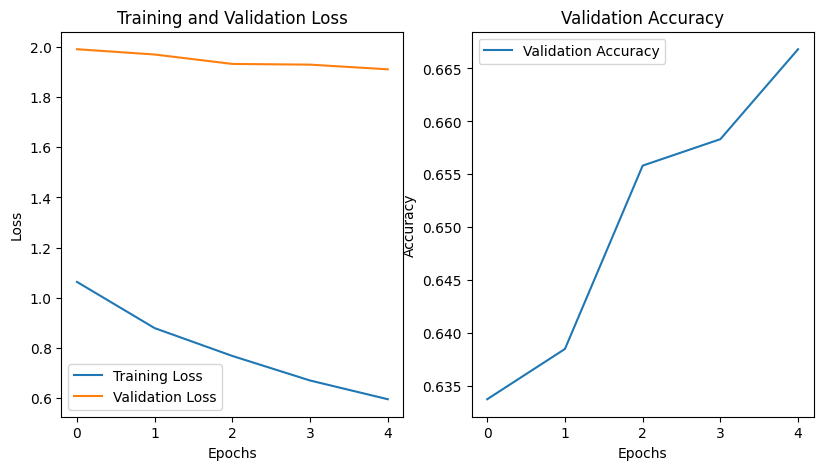

In [58]:
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(trainLoss, label='Training Loss')
plt.plot(valLoss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(valAccuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

## Evaluation - Part 3

###Running model on test set

In [59]:
model.eval()
model.to(device)

testDir = "./face_data/dataset/test"

In [60]:
results = []

testImages = sorted(os.listdir(testDir))
total = len(testImages)
print(f"Test images: {total}")

with torch.no_grad():
    for i, imageName in enumerate(testImages, 1):
        imagePath = os.path.join(testDir, imageName)
        image = Image.open(imagePath).convert('RGB')
        # Apply transformations (from part one)
        image = test_transform(image).unsqueeze(0).to(device)

        output = model(image)
        pred = output.argmax(dim=1).item()

        imageName = int(os.path.splitext(imageName)[0])
        results.append({'image_name': imageName, 'label': pred})

        if i % max(1, total // 5) == 0 or i == total:
            print(f"Completed {i} / {total} images")


Test images: 35000
Completed 7000 / 35000 images
Completed 14000 / 35000 images
Completed 21000 / 35000 images
Completed 28000 / 35000 images
Completed 35000 / 35000 images


Saving predictions to CSV

In [61]:
df = pd.DataFrame(results).sort_values(by='image_name')
df.to_csv("result.csv", index=False)
print("Predictions saved to result.csv")

Predictions saved to result.csv


Fixing CSV Formatting

In [62]:
idx_to_class = {v: k for k, v in data.class_to_idx.items()}
df['label'] = df['label'].map(idx_to_class)

# adding file type ot name as required
df['image_name'] = df['image_name'].astype(str) + '.jpg'

df.to_csv("result.csv", index=False)
print("Formatted result.csv saved.")

Formatted result.csv saved.


In [63]:
csv_path = './'
os.makedirs(csv_path, exist_ok=True)
df.to_csv(os.path.join(csv_path, 'MobileNetResult.csv'), index=False)
print(f"file saved at: {csv_path}")

file saved at: ./
